# Gun Detection System for Urban Settings (_Data cleaning, pre processing and augmentation_)

This notebook contains the description and the pre-processing details of the dataset used in the implemetation of th **gun detection system** for the detection of gunshots sounds in urban settings.  

In [1]:
import librosa
import numpy as np
from numpy import nan
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import math
from PIL import Image
import os

import warnings
warnings.filterwarnings('ignore')
matplotlib.use("Agg")
%matplotlib inline

First, some constant values are set to be used across the entire notebook

In [2]:
IMG_DIR = "./mel-specs"
VAL_DIR = "./mel-specs-val"
TEST_DIR = "./mel-specs-test"

SAMPLE_RATE = 22050 # Justification for this value is provided later

## I. Explanatory data analysis

The dataset consists of 8732 labelled sound files, each with a length of less than or equal to 4 seconds. The sound files represent urban sounds from different scenarios. The sounds are classified into ten different classes: air conditioner, car horn, children playing, dog barking, drilling, idle engine, gunshot, jackhammer, siren, and street music. The audio dataset comprises audio files that are extracted from longer audio recordings, containing only the relevant sounds of the intended action and without additional silence or unnecessary noise.


For the current task, only one class is relevant out of the ten classes, the gunshot class. Detecting a gunshot sound is relevant to gunshot detection systems. By identifying and isolating the gunshot class from the rest of the urban sounds, machine learning models can be trained to recognize the unique acoustic characteristics of a gunshot sound.

The csv file called `data-description.csv` contains a description of all audio files included in the dataset. To perform explanatory data analysis, the csv file is loaded into pandas DataFrame.

In [3]:
df = pd.read_csv('./data-description.csv')
df.shape

(8732, 8)

In [4]:
label_map = {
    'air_conditioner': 0,
    'car_horn': 1,
    'children_playing': 2,
    'dog_bark': 3,
    'drilling': 4,
    'engine_idling': 5,
    'gun_shot': 6,
    'jackhammer': 7,
    'siren': 8,
    'street_music': 9,
}

def get_class_name(idx):
    return list(label_map.keys())[list(label_map.values()).index(idx)]

Each row in the dataframe named `df` represents the metadata for one audio file. For each audio file, the following details are included:
- Name of the file.
- The recording sound ID.
- The start time of the slice in the original audio.
- The end time of the slice in the original audio.
- salience, an indicator for whether the sound slice is a foreground sound (1) or background sound (2).
- ID of the class to which the sound slice belongs.
- Name of the class to which the sound slice belongs.

In [5]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


To get better insight into the range of audio lengths included in the data, a new column will be added resresenting the length of the sound calculated by the subtracting the the start timestamp from the end.

In [6]:
df['length'] = df['end'] - df['start']

Furthermore, to get better insight into the range of different sample rates included in the data, a new column will be added resresenting the sample rate of the individual slice. <br/> <br/>
To get the sample rate, librosa's `get_samplerate` function will be applied on each audio slice to extract the relevant rate. The sample rates will then be saved into a new column called `sample_rate`.

In [7]:
sample_rate = np.zeros(df.shape[0])
for index, row in df.iterrows():
    sample_rate[index] = librosa.get_samplerate('./audio/fold' + str(row['fold']) + '/' + row['slice_file_name'])
    
df['sample_rate'] = sample_rate  

In [8]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,length,sample_rate
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,0.317551,44100.0
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,4.000000,44100.0
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,4.000000,44100.0
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,4.000000,44100.0
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,4.000000,44100.0


In [9]:
df.describe().round(2)

,fsID,start,end,salience,fold,classID,length,sample_rate
count,8732.00,8732.00,8732.00,8732.00,8732.00,8732.00,8732.00,8732.00
mean,116033.49,38.65,42.25,1.35,5.39,4.59,3.61,48456.98
std,57991.02,74.29,74.37,0.48,2.85,2.89,0.97,15300.08
min,344.00,0.00,0.11,1.00,1.00,0.00,0.05,8000.00
25%,69942.25,3.00,6.84,1.00,3.00,2.00,4.00,44100.00
50%,118279.00,10.38,14.00,1.00,5.00,4.00,4.00,44100.00
75%,166942.00,35.13,38.87,2.00,8.00,7.00,4.00,48000.00
max,209992.00,600.13,604.13,2.00,10.00,9.00,4.00,192000.00


### File format

All files are in the Waveform Audio File Format (.wav), eliminating the need for any format conversion. 

In [10]:
[x for x in df['slice_file_name'] if '.wav' not in x]

[]

### Lengths variation

As can be seen in the following table, different classes have different range of sound lengths. The shortest sound slice belongs to the `car_horn` with only 5 ms. All classes have a maximum lengths of 4 seconds.

The `gun_shot` class, the class of interest has a minimum lengths of 0.17 seconds with a mean of 1.65 seconds.

In [11]:
'mean across all classes: {}'.format(round(np.mean(df['length']), 2))

'mean across all classes: 3.61'

### Sample Rate variation

As can be seen the following chart, audio clips differ in sample rate. The sample rates range from 32 kHz to 44.1 kHz. The majority of clips have a sample rate of more than or equal to 96 kHz.

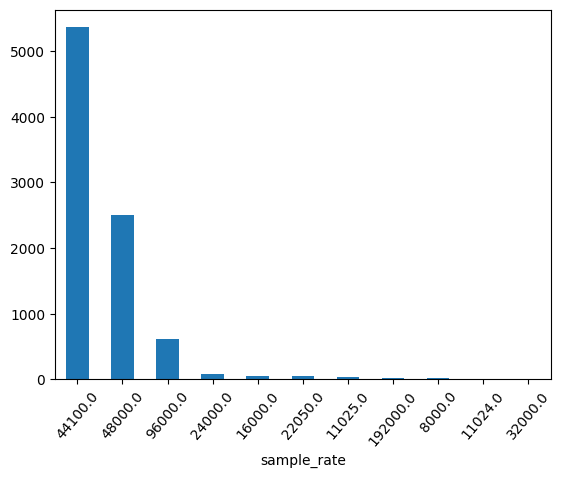

In [12]:
df['sample_rate'].value_counts().plot.bar(x='sample_rate', y='count', rot=50);

### Foreground vs. background

Each class contains both foreground and background noises. Some classes (e.g. engine_idling and gun_shot) contain far more foreground noises than background. This adds variation to the classes to help introduce the machine learning classifer to different versions of the audio sounds imitating real life noises.

In [13]:
df.groupby(['class', 'salience']).size()

class             salience
air_conditioner   1           569
                  2           431
car_horn          1           153
                  2           276
children_playing  1           588
                  2           412
dog_bark          1           645
                  2           355
drilling          1           902
                  2            98
engine_idling     1           916
                  2            84
gun_shot          1           304
                  2            70
jackhammer        1           731
                  2           269
siren             1           269
                  2           660
street_music      1           625
                  2           375
dtype: int64

### Class distribution

Based on the following chart, there is a huge class imbalance in the data. Eight out of the ten classes have an equal number of audio samples, with 1000 instances per class. However, the car horn, and gunshot classes are significantly underrepresented in the dataset. This poses a great challenge for the current task, particularly as the gunshot class is the class of interest. With only 4.3% of all samples, the gunshot class has the least number of instances. Resampling the dataset is necessary in this case.

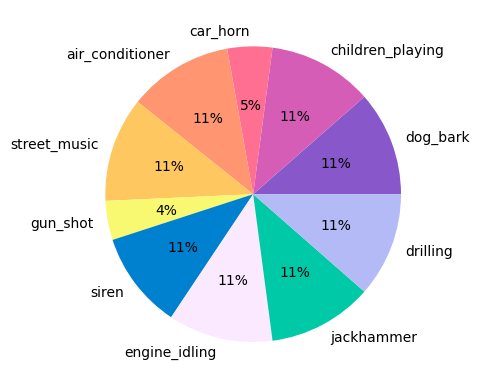

In [14]:
def get_class_dist(df, label, plot=False):
    count_per_class = {}
    for index, row in df.iterrows():
        y = row[label]
        if(y not in count_per_class):
            count_per_class[y] = 0
        count_per_class[y] += 1
    if plot:
        colors = ['#8858Ca', '#D65DB6', '#FF6F91', '#FF9671', '#FFC75F', '#F9F871', '#0081CF', '#FBEAFF', '#00C9A7', '#b3bAf6' ]
        plt.pie(list(count_per_class.values()), labels = list(count_per_class.keys()), colors=colors, autopct='%.0f%%')
        plt.show()
    
    return count_per_class

get_class_dist(df, 'class', True);

## II. Data pre-processing

In this section, the neccessary data pre-processing techniques are applied to prepare the data for training, validation and testing.

To make sure all sounds have the same sample rate, the sample rate for all loaded audio files will be set at 22.05 kHz. <br/>
Despite most of the data having an original sample rate of 44.1 kHz, this value was chosen as it is considered a middle value between the smallest and the highest sample rates in this case. Oversampling very low rates to a very high rate value such as 44.1 kHz might distort the sound and lead to the loss of valuable features. On the other hand, undersampling high rates to a slightly smaller value will not hugely affect the quality. <br/> <br/>
The Python library librosa will be used to load and process the audio files. One of the notable features of this library is its ability to automatically resample audio files during loading, which is highly advantageous for facilitating sample rate conversion. 

In [15]:
SAMPLE_RATE

22050

The audio files are split into 10 folders. The following cell sets the path to each of those folders.

In [88]:
AUDIO_DIR = './audio' # path to audio files directory
folders = ['fold{}'.format(x) for x in range(8, 9)] # array of paths to each audio folder

In [89]:
slices = np.zeros(df.shape[0], dtype=object)
slices[:] = np.nan # placeholder array for audio slices
classes = np.array(df['class']) # list of audio classes

### Loading the data

In [90]:
for fold in folders:
    print('collecting {}...'.format(fold), end = "")
    files = librosa.util.find_files('{}/{}'.format(AUDIO_DIR, fold), ext=['wav'])
    files = np.asarray(files)
    for file in files:
        if '.wav' in file:
            name = file.split('/').pop()
            wave_arr, sr = librosa.load(file, sr = SAMPLE_RATE, mono = True)
            idx = list(df.index[df['slice_file_name'] == name])[0]
            slices[idx] = wave_arr.astype(object)
    print("done!")

collecting fold8...done!


Slices array shape: (8732,)


AttributeError: 'float' object has no attribute 'astype'

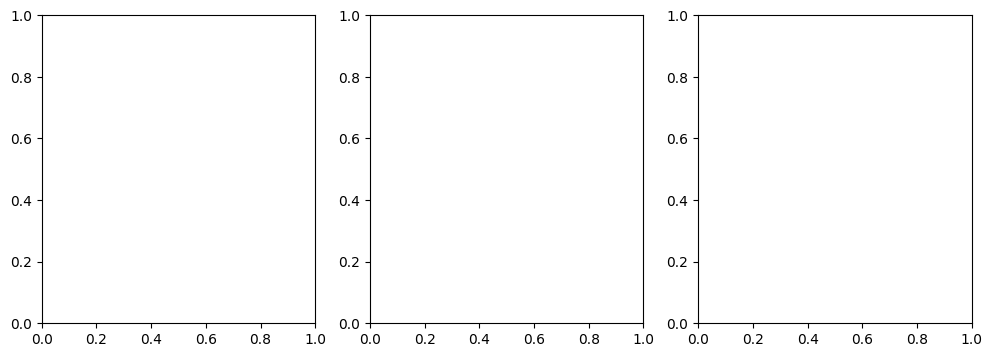

In [91]:
import random

print('Slices array shape: {}'.format(slices.shape))

fig, ax =  plt.subplots(nrows=1, ncols=3, sharex=True)
fig.set_size_inches(12, 4)
for i in range(3):
    idx = random.randint(0, len(slices) - 1)
    y = slices[idx]
    librosa.display.waveshow(y.astype(float), sr=SAMPLE_RATE, ax=ax[i])
    plt.axis('off')
plt.show()

### II.I Data cleaning

In order to perform an accurate analysis of the audio dataset, it is important to ensure that each audio file contains sufficient information and features for the task at hand. To achieve this, any audio files that have a duration of fewer than 0.30 seconds will be removed from the dataset. This will eliminate extremely short audio files and ensure that the remaining files provide adequate information for analysis. 

In [92]:
MIN_LEN = 0.30

small_slices_idx = list(df.loc[df['length'] < MIN_LEN].index)
for idx in small_slices_idx:
    slices[idx] = np.nan
    classes[idx] = np.nan
    
slices = slices[~pd.isnull(slices)]
classes = classes[~pd.isnull(classes)]

df_clean = df.loc[df['length'] >= MIN_LEN]

print('{} instances removed'.format(df.shape[0] - df_clean.shape[0]))

67 instances removed


### II.II Audio Splitting

Generally, it is advisable to split the formatted audio files into several **equal** brief segments with predetermined time intervals. For this project, a threshold value of 2 seconds is set for all clips. Two seconds is a suitable threshold as it is equal to half of the maximum lengths of all classes. It is also slightly higher than the mean length of the interest class (1.65 s) and less than the mean length across all classes (3.61 s).

In [93]:
goal_len = 2

In [94]:
length_of_wave_arr = round(goal_len * SAMPLE_RATE) # the length of the desired slices segments arrays
length_of_wave_arr

44100

The following function splits audio slices using the following algorithm:
1. If the slice is 2 seconds long, keep it as it is.
2. If the slice is less than 2 seconds long, pad with silence.
3. If slice is longer, the audio is split into two segments; the first segment is 2 seconds long, and the second segment is the remainder of the clip.
4. If the second segment is shorter than 0.30 seconds, it will be discarded.
5. If the second segment is larger than or equal to 2 seconds: <br/>
    5.1. If it belongs to either the gun_shot or the car_horn class, the new seqment will be added to the queue and will then undergo the same process from step 1. This will add more instances to the two under-represented classes. <br/>
    5.2. If it belongs to any of the other eight classes, the segment is discarded. This is done to avoid adding more instances to the larger classes, further increasing the gap in the class imbalance.

In [95]:
def split_audio_slices(slices, classes, split_length=length_of_wave_arr):
    X = slices.copy()
    y = classes.copy()
    
    idx = 0
    while idx < X.shape[0]:
        _slice = X[idx]
        _class = y[idx]
        
        if(_slice.shape[0] == split_length): # If it is already 2 seconds long, skip.
            idx += 1
            continue
            
        elif(_slice.shape[0] < split_length):  # If it is less than 2 seconds long
            diff = split_length - _slice.shape[0]
            silence = np.zeros(split_length) # silence
            lead = silence[0 : math.ceil(diff / 2)]
            trail = silence[0 : math.floor(diff / 2)]
            
            X[idx] = np.concatenate((lead, _slice, trail)) # pad with silence
        
        else:
            # split into two segments
            seg1 = _slice[:length_of_wave_arr]
            seg2 = _slice[length_of_wave_arr:]
            
            X[idx] = seg1
            
            # If it is longer than 2 s and belongs to the small classes
            # add to the queue to undergo another split/silence padding
            if(seg2.shape[0] >= MIN_LEN and (_class == 'gun_shot' or _class == 'car_horn')):
                X = np.array(list(X) + list(np.array([seg2])), dtype=object )
                y = np.append(y, _class)
                
        idx += 1
        
    return X, y

In [96]:
X, y = split_audio_slices(slices, classes)

After splitting the large audio slices of the small classes and adding them back to the queue, it is noticed that the dataset size was increased.

In [97]:
X.shape, y.shape, len([x for x in list(X) if len(x) == length_of_wave_arr])

((814,), (8675,), 814)

The gun_shot class instances were increased by 1% while the car_horn class was increased by 2%.

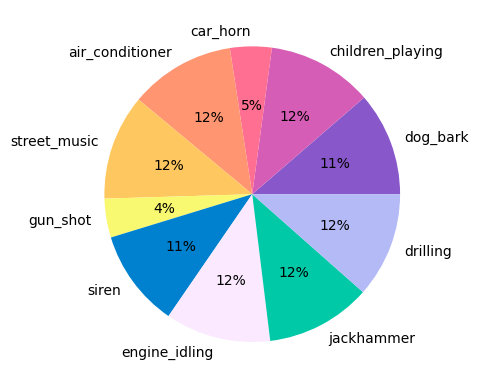

In [98]:
counts_per_class = get_class_dist(pd.DataFrame(y, columns=['class']), 'class', True);

### II.III Data splitting

Before further processing, the data is split to avoid data leakage. The data is split into 80%, 10% and 10% for training, validation and testing, respectively.

In [34]:
from sklearn.model_selection import train_test_split

_X, X_test, _y, y_test = train_test_split(X, y, test_size=0.10, random_state=101)
X_train, X_val, y_train, y_val = train_test_split(_X, _y, test_size=0.10, random_state=101)

ValueError: Found input variables with inconsistent numbers of samples: [998, 8675]

### II.IV Data augmentation

In [99]:
get_class_dist(pd.DataFrame(y, columns=['class']), 'class') 

{'dog_bark': 984,
 'children_playing': 1000,
 'car_horn': 395,
 'air_conditioner': 1000,
 'street_music': 1000,
 'gun_shot': 369,
 'siren': 927,
 'engine_idling': 1000,
 'jackhammer': 1000,
 'drilling': 1000}

Even with the slight increase with data splitting, the gun_shot and car_horn classes still contain the least ammount of instances

To decrease the class imbalance, and to further increase the count of the smaller classes, data augmentation techniques will be applied to the smaller classes. <br/>
Two data augmentation methods are applied, noise induction and time shifting. Each class is capped at 700 instances.

In [100]:
MIN_CLASS_COUNT = 700

In [77]:
import random
import time

def augment_class(data, labels, name, n_instances):
    '''augments n_instances of the given class name'''
    print('Augmenting for {}...'.format(name), end='')
    shift_aug = math.ceil(n_instances / 2) # 50% will undergo time shift augmentation
    noise_aug = math.floor(n_instances / 2) # the other 50% will undergo noise induction augmentation
    
    new_data = []
    count = 0 # counts the number of newly added instances
    idx = 0
    while count < n_instances and idx < len(data):
        if labels[idx] == name:
            _slice = data.iloc[idx][0]
            if count < shift_aug:
                shift = int((random.randint(5, 20)/100) * len(_slice))
                new_slice = np.roll(_slice, shift)
            else:
                new_slice = _slice + 0.01 * np.random.normal(0,1,len(_slice))
                
            data.loc[len(data)] = [new_slice]
            labels = np.append(labels, name)
            count += 1
            
        idx += 1
        if(idx == len(data) and count < n_instances):
            idx = 0
            
    print('done!')
    return  data, labels

In [101]:
class_counts = list(get_class_dist(pd.DataFrame(y, columns=['class']), 'class').items())

for _class in class_counts:
    name, count = _class
    if count < MIN_CLASS_COUNT:
        X, y = augment_class(pd.DataFrame(X), y, name, MIN_CLASS_COUNT - count)

Augmenting for car_horn...done!
Augmenting for gun_shot...done!


In [102]:
class_counts = list(get_class_dist(pd.DataFrame(y, columns=['class']), 'class').items())
class_counts

[('dog_bark', 984),
 ('children_playing', 1000),
 ('car_horn', 700),
 ('air_conditioner', 1000),
 ('street_music', 1000),
 ('gun_shot', 700),
 ('siren', 927),
 ('engine_idling', 1000),
 ('jackhammer', 1000),
 ('drilling', 1000)]

### II.V Data resampling

To completely eleminate the remaining class imbalance, data resampling will be applied. <br/>
The interest class, `gun_shot`, now contains exactly 700 instances which is the minimum class count among all other classes. For this reason, data **under-sampling** is applied. Under sampling will help avoid introducing fake instances to the interest class specially after applying augmentation to the same class. This will ensure the reliability of the available data.

In [103]:
import imblearn

In [104]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

IndexError: indices are out-of-bounds

In [ ]:
len(X_resampled)

NameError: name 'X_resampled' is not defined

The training set is now equally split into 10 classes

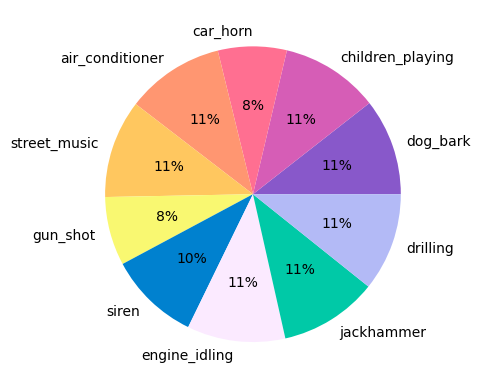

{'dog_bark': 984,
 'children_playing': 1000,
 'car_horn': 700,
 'air_conditioner': 1000,
 'street_music': 1000,
 'gun_shot': 700,
 'siren': 927,
 'engine_idling': 1000,
 'jackhammer': 1000,
 'drilling': 1000}

In [105]:
get_class_dist(pd.DataFrame(y, columns=['class']), 'class', True)

---

Here, the 3 data sets are converted again to wav form and saved to disk to be loaded again as sound files for future use.

In [108]:
import soundfile as sf

def export_x_and_y_helper(x, y, dir_path):
    for idx in range(len(x)):
        arr = x[idx]
        label = y[idx]
        # name of the file is formatted as follows: {index}-{classID}
        filename = '{}/{}-{}.wav'.format(dir_path, idx, label_map[label])
        
        sf.write(filename, arr.astype(float), SAMPLE_RATE)
        
def export_x_and_ys():
    path = './processed_data'
    if not os.path.exists(path):
        os.mkdir(path)
        os.mkdir('{}/train'.format(path))
        os.mkdir('{}/val'.format(path))
        os.mkdir('{}/test'.format(path))
        
    print('Exporting training set...', end='')
    export_x_and_y_helper(X[0], y, '{}/test'.format(path))
    print('done!')
    

In [109]:
export_x_and_ys()

Exporting training set...done!
